#### File used to compare the losses used in DEEPLAB:
1. Cross Entropy
2. 0.5 * Cross Entropy +  0.5* Lovász-Softmax

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:


def analyze_and_plot_miou_runtime(csv_label_list):
    """
    Carica più CSV e visualizza:
    - Curve val_mIoU (con eventuale punto finale)
    - Scatter mIoU vs Tempo Totale di Training

    Parametri:
    ----------
    csv_label_list : list of tuples
        Lista di tuple (csv_path, label), dove 'label' è il nome mostrato nei grafici.

    Ritorna:
    --------
    results : list of dict
        Ogni dict ha chiavi 'label', 'miou', 'runtime', 'df_extended'
    """

    results = []
    plt.figure(figsize=(14, 7))

    for csv_path, label in csv_label_list:
        df = pd.read_csv(csv_path)

        cols = ['epoch', 'val_mIoU']
        if 'Runtime' in df.columns:
            cols.append('Runtime')

        df_clean = df[cols].dropna().sort_values(by='epoch')
        df_extended = df_clean[['epoch', 'val_mIoU']].copy()

        # Punto finale se disponibile
        show_final = False
        if 'val_mIoU_final' in df.columns and df['val_mIoU_final'].notna().any():
            final_row = df[['epoch', 'val_mIoU_final']].dropna().sort_values(by='epoch').iloc[-1]
            max_epoch = df_extended['epoch'].max()

            if max_epoch < final_row['epoch']:
                final_point = pd.DataFrame([{
                    'epoch': final_row['epoch'],
                    'val_mIoU': final_row['val_mIoU_final'],
                }])
                df_extended = pd.concat([df_extended, final_point], ignore_index=True)
            else:
                df_extended.loc[df_extended['epoch'].idxmax(), 'val_mIoU'] = final_row['val_mIoU_final']

            show_final = True

        # Plot curva
        line, = plt.plot(df_extended['epoch'], df_extended['val_mIoU'],
                         label=label, linestyle='-', marker='o')
        if show_final:
            plt.text(final_row['epoch'] + 0.3, final_row['val_mIoU_final'],
                     f"{final_row['val_mIoU_final']:.2f}% (final)",
                     color=line.get_color(), ha='left', va='bottom', fontsize=9)

        # Calcolo runtime e mIoU finale
        total_runtime_min = df_clean['Runtime'].sum() / 60 if 'Runtime' in df_clean.columns else None

        epoch_50_row = df[df['epoch'] == 50]
        if not epoch_50_row.empty:
            val_miou_final_50 = epoch_50_row.iloc[0].get('val_mIoU_final', None)
            if pd.notna(val_miou_final_50):
                final_miou = val_miou_final_50
            else:
                final_miou = epoch_50_row.iloc[0]['val_mIoU']
        else:
            final_miou = df_extended.iloc[-1]['val_mIoU']

        results.append({
            'label': label,
            'miou': final_miou,
            'runtime': total_runtime_min,
            'df_extended': df_extended
        })

    # Mostra primo plot (curve)
    plt.xlabel('Epoch')
    plt.ylabel('Validation mIoU')
    plt.title('Validation mIoU Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Secondo plot: mIoU vs Runtime
    plt.figure(figsize=(10, 6))
    runtimes = [r['runtime'] for r in results]
    mious = [r['miou'] for r in results]
    labels = [r['label'] for r in results]

    plt.scatter(runtimes, mious, color='blue')

    offset_x = (max(runtimes) - min(runtimes)) * 0.01 if len(runtimes) > 1 else 0.5
    offset_y = (max(mious) - min(mious)) * 0.01 if len(mious) > 1 else 0.05

    for i, label in enumerate(labels):
        plt.text(runtimes[i] + offset_x, mious[i] + offset_y,
                 f"{label}\nTime: {runtimes[i]:.2f} min\nmIoU: {mious[i]:.2f}%",
                 fontsize=9, ha='left', va='bottom')

    plt.xlabel('Total Training Time (minutes)')
    plt.ylabel('Final Validation mIoU (%)')
    plt.title('Trade-off: mIoU vs. Total Training Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results


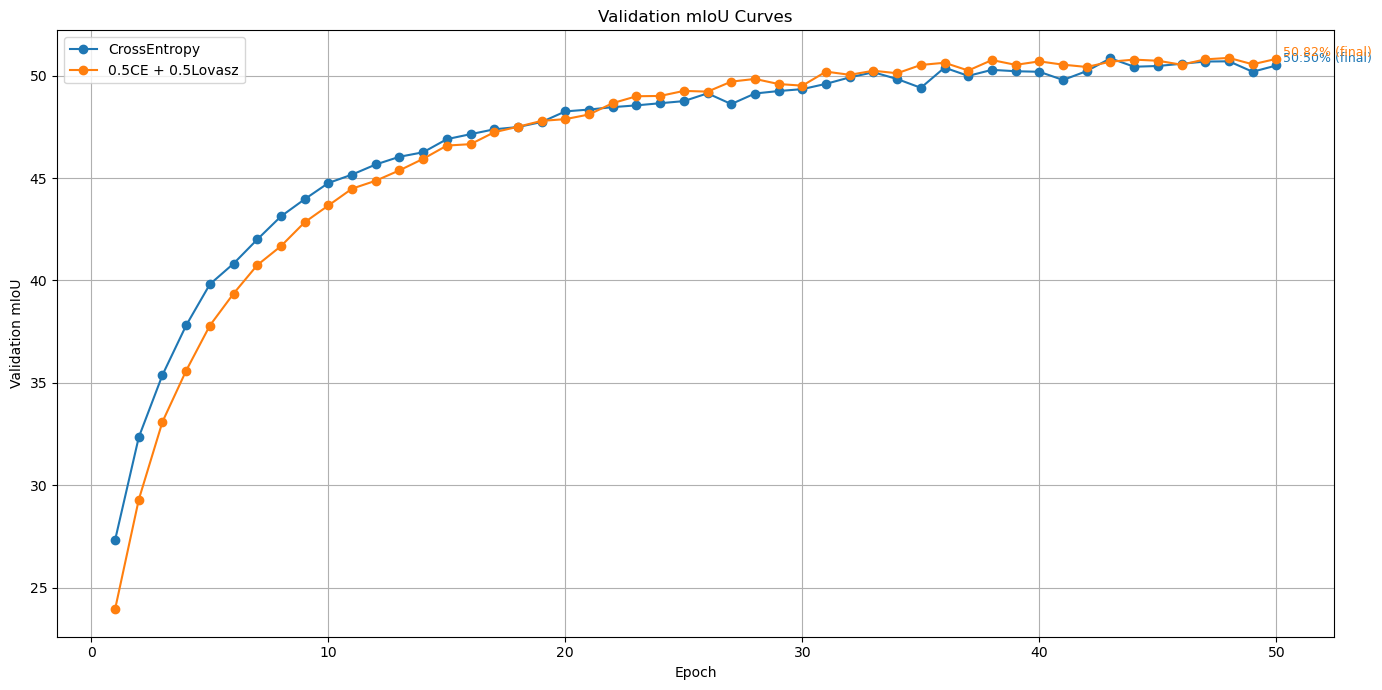

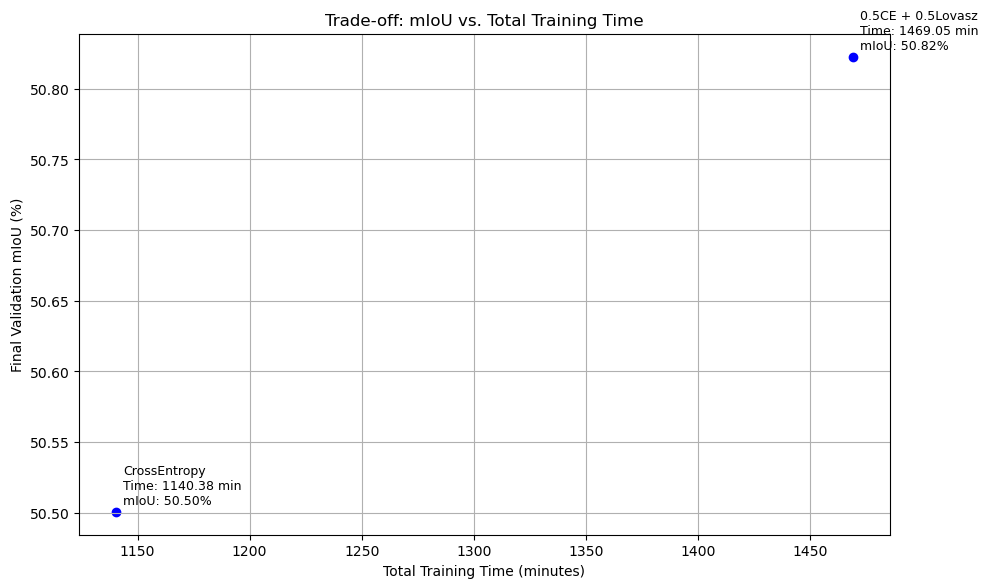

In [15]:
results = analyze_and_plot_miou_runtime([
    ("wandb_export_2025-05-17T16_57_05.534+02_00.csv", "CrossEntropy"),
    ("wandb_export_2025-05-15T16_12_48.823+02_00.csv", "0.5CE + 0.5Lovasz"),
])


NON HA SENSO CONSDIERA RUNTIME PERCHE PER CROSS ENTROPY DA 26 IN POI HO USATO KAGGLE GPU P100 CHE CI METTEVA CIRCA 11 MINUTI IN MENO A EPOCA.
QUINDI SE FACCIO 1140.38 + 25* 10.8 = 1410 (un po meno).
COMUNQUE RISULTATI SIMILI.